<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script calculate the differences between the radiosoundings of MOSAiC and them of ERA5.

It will be used to realize unsupervised machine learning (self-organizing maps) on relative humidity. 

### IMPORT

In [3]:
import numpy as np
from netCDF4 import Dataset as ncfile
import matplotlib.dates as dates
import datetime

### READ DATA

In [4]:
date_min = '20200101000000'
date_max = '20200131180000'
task_ID = 1 #$TASK_ID

In [5]:
"""Function that create a list of dates and take the date corresponding to the index giving by the bash script."""
def task_date(date_min, date_max, task_ID):
    current_date = datetime.datetime.strptime(date_min, '%Y%m%d%H%M%S')
    end_date = datetime.datetime.strptime(date_max, '%Y%m%d%H%M%S')
    list_date = []
    while current_date <= end_date:
        list_date.append(current_date.strftime('%Y%m%d%H%M%S'))
        current_date = current_date + datetime.timedelta(hours = 6)
    date_task = list_date[task_ID - 1]
    return(date_task)

In [6]:
date_task = task_date(date_min,date_max,task_ID)

In [7]:
year=date_task[0:4] ; month=date_task[4:6] ; day=date_task[6:8] ; hour=date_task[8:10]

ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'+year+'/'+month+'/'
data_link  = ppidir + 'collocated_ERA5_MOSAiC_'+year+month+day+hour+date_task[10:12]+date_task[12:14]+'.nc'

data = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [8]:
pres = data.variables['pres'][:]
lat = data.variables['lat_mosaic'][:] 
lon = data.variables['lon_mosaic'][:]
time = data.variables['time_mosaic'][:]
era5_temp = data.variables['temp_era5'][:]
era5_rh = data.variables['rh_era5'][:]
era5_wdir = data.variables['wdir_era5'][:]
era5_wspeed = data.variables['wspeed_era5'][:]
mosaic_temp = data.variables['temp_mosaic'][:]
mosaic_rh = data.variables['rh_mosaic'][:]
mosaic_wdir = data.variables['wdir_mosaic'][:]
mosaic_wspeed = data.variables['wspeed_mosaic'][:]

In [9]:
temp_bias = era5_temp-mosaic_temp
rh_bias = era5_rh-mosaic_rh
wspeed_bias = era5_wspeed-mosaic_wspeed

In [19]:
# need to use direction errors
wdir_bias = era5_wdir-mosaic_wdir
for i in range(len(wdir_bias)) :
    if wdir_bias[i] > 180 :
        wdir_bias[i] = wdir_bias[i]-360
    if wdir_bias[i] < -180 :
        wdir_bias[i] = wdir_bias[i]+360
    

In [20]:
wdir_bias

masked_array(data=[ 33.22008047,  -5.48603048, -20.60749972,  14.65380819,
                    -8.85257812,   8.41367486,   8.91292444,  17.40720637,
                     3.99567924,   5.30317881, -19.49460829, -15.88276864,
                    -3.96719573,  -7.63032975,  -8.06641309,  -6.08334575,
                    -1.86389207, -13.12275022,  -2.51035268, -13.1252631 ,
                    -3.57604964,  -4.05530034,  -0.89447035,   0.37605199,
                    -5.6195476 ,  -0.13357133,  -1.31637214,  -6.07623349,
                    10.35964901],
             mask=False,
       fill_value=1e+20)

### PLOT

In [21]:
def plotbiases() :
    
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt

    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                  'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)

    fig, axs = plt.subplots(1,4,figsize=(30,15))
    axs[0].plot(temp_bias,pres, 'C0')
    axs[0].invert_yaxis()
    axs[0].set_xlabel ('T [K]')
    axs[0].set_ylabel ('Pressure [hPa]')

    axs[1].plot(rh_bias, pres, 'C0')
    axs[1].invert_yaxis()
    axs[1].set_xlabel ('RH [%]')

    axs[2].plot(wdir_bias,pres, 'C0')
    axs[2].invert_yaxis()
    axs[2].set_xlabel (r'Wind direction [degree]')

    axs[3].plot(wspeed_bias,pres, 'C0')
    axs[3].invert_yaxis()
    axs[3].set_xlabel (r'Wind speed [$m.s^{-1}$]')


    date = day + '/' + month + '/' + year + ' ' + hour + ':' + date_task[10:12] + ':' + date_task[12:14]
    fig.suptitle(date, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    plt.savefig(path_fig+'fig_biases_'+date_task+'.png')

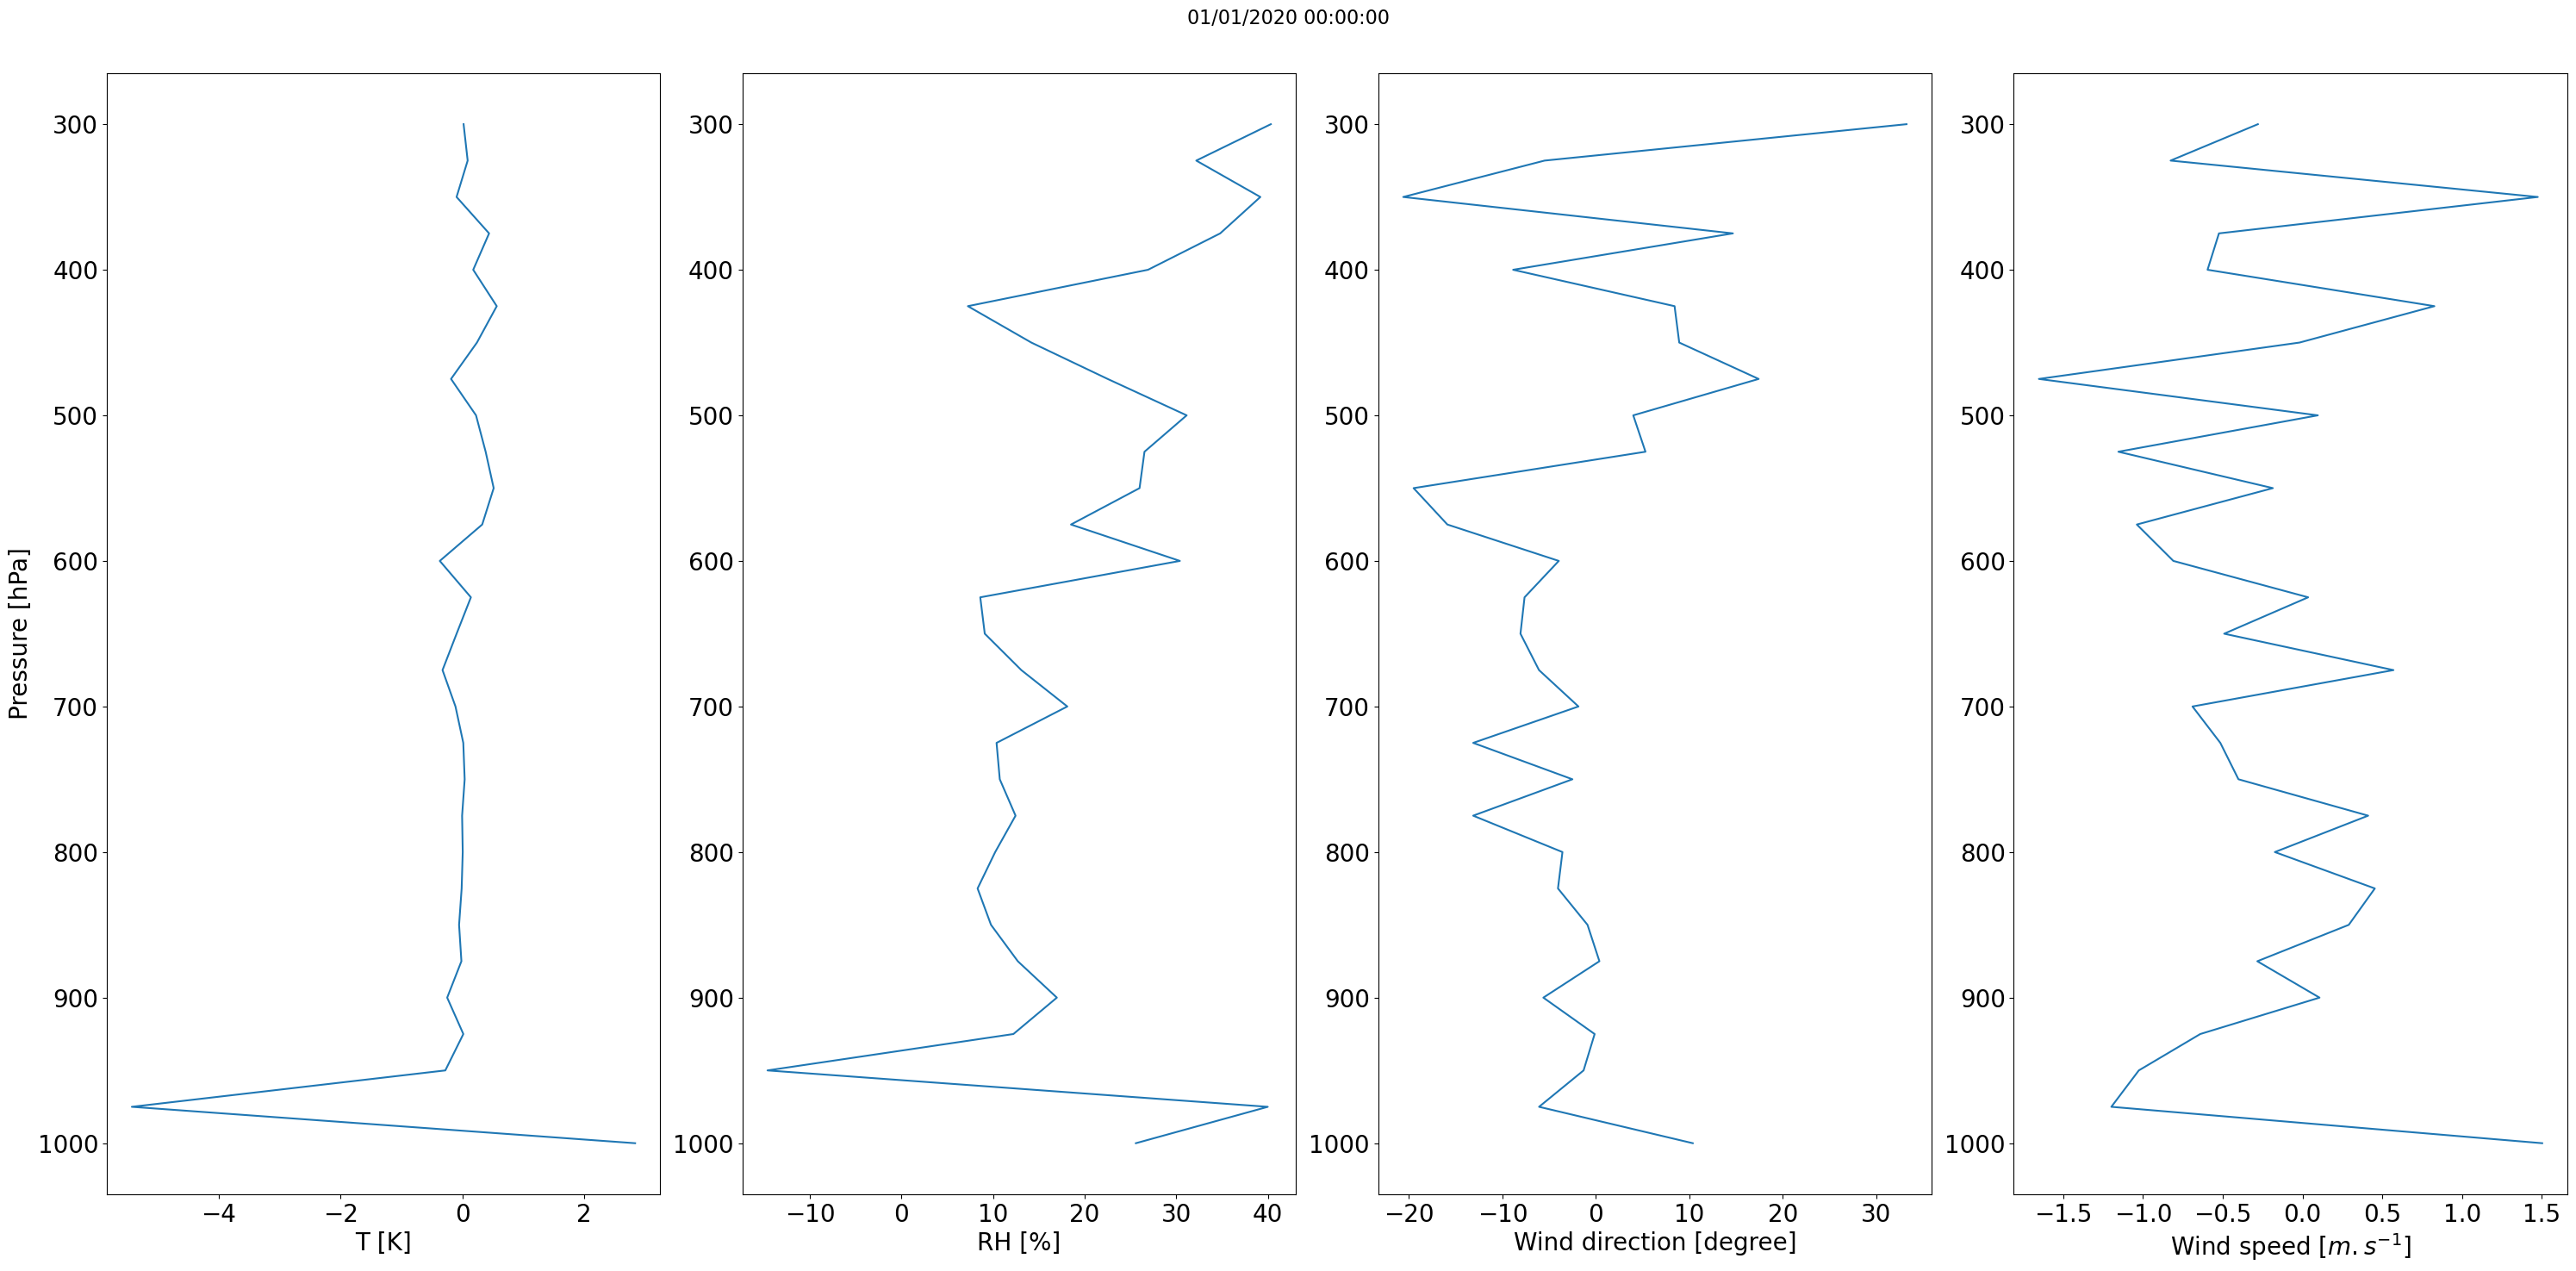

In [22]:
plotbiases() #comment this line to not plot figures
#positive = surestimation in ERA5